### Import all required modules

In [ ]:
import distinctipy
import matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyfftw  # FFTW used in Matlab.
import time
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

# Constants
c = 299792458  # speed of light in m/s
q = 1.60217646E-19                         # electronic charge
permittivity = 8.854187817620E-12          # permittivity of free space

# Bandwidth range
bandwidth = ()
bandwidth_xlim = (-0.01, 10)
bandwidth_ylim = (2, 1e5)

fontsize = 25
tick_fontsize = 15
figure_size_3 = (10, 13)
figure_size_2 = (18, 6.5)
figure_size_1 = (15, 6.5)


### Sample attributes
When the file type is json or hfd5, sample and experimental attributes may be saved within the file for convenience. This function helps to extract those attributes. Typically, attributes will be saved as strings.

Available attributes: <br>
**Sample**:
- Sample name
- Sample type (thin films, nanowires, etc)
- Sample thickness/diameter
- Sample reference
- Sample description
- Passivation layer
- Temperature
- Sample fabriation technique

**Experimental**:
- Pump fluence
- Vacuum/purged conditions
- Emitter & detector
- Pump wavelength


### Reminder of sampling scheme
Sampling scheme is dependent on the frequency at which we chop the THz generation pulse, and the pump pulse. Current default is 2500 Hz and 1250 Hz respectively, but one must always adjust the code accordingly, or better yet, encode it within the experimentation program so ABCD signal would always adhere to the following scheme:

## Pulses schematic
A: E_on + pump + gate pulse <br>
B: Pump + gate pulse        <br>
C: E_off + gate pulse       <br>
D: Gate pulse (balance)

Therefore, to get the relevant information: <br>
**Dark THz signal**:<br>
&nbsp;&nbsp;&nbsp;&nbsp;- *E_off* = (C - D)<br>
**Pump THz signal**:<br>
&nbsp;&nbsp;&nbsp;&nbsp;- *E_on* = (A - B)<br>
**Change in sample properties between excited and unexcited states**:<br>
&nbsp;&nbsp;&nbsp;&nbsp;- *DT* = (A - B) - (C - D)<br>
**Sample THz emission**: <br>
&nbsp;&nbsp;&nbsp;&nbsp;- *sample_emission* = (B - D)



In [151]:
def generate_legacy_dataframe(filepath):
    """
    Similar to generate_cleaned_up_dataframe, but for txt files 
    generated by the legacy LabVIEW program.
    """
    if filepath.endswith('.txt'):
        dataframe = pd.read_csv(filepath, sep="	", header=0)
    dataframe.rename(columns={'%X(mm)':'Delay (mm)'}, inplace=True)
    dataframe = dataframe.sort_values(by='Delay (mm)')
    dataframe = dataframe.reset_index(drop=True)

    # convert position of delay stage to time delay (in seconds)
    dataframe.insert(1, 'Delay (s)', dataframe['Delay (mm)']*((2E-3)/c))

    # Get E on, E off, Delta E and their respective FFTs
    dataframe.rename(columns={'T':'E_off'}, inplace=True)
    dataframe.insert(3, 'fft_E_off', pyfftw.builders.fft(dataframe['E_off'])())
    dataframe.rename(columns={'DT':'Delta_E'}, inplace=True)
    dataframe.insert(2, 'fft_Delta_E', pyfftw.builders.fft(dataframe['Delta_E'])())

    # calculate the frequencies, f, at which the fft is taken
    num_data_points = len(dataframe)
    double_bandwidth = num_data_points/(dataframe['Delay (s)'].iloc[-1] -
                                        dataframe['Delay (s)'].iloc[0])
    dataframe.insert(2, 'Frequencies (Hz)', np.linspace(0, double_bandwidth, num_data_points))

    return dataframe

def generate_cleaned_up_dataframe(filepath):
    """
    Automatically reads data files with extension .txt and .hfd5.
    Cleans up the dataframe by sorting the delay.
    Also adds columns for E_on, E_off, Delta_E and their respective FFTs.
    Also adds a column for the frequencies at which the FFTs are taken.
    """
    # TODO: Add file type handling (e.g., .txt, .hdf5)
    if filepath.endswith('.txt'):
        dataframe = pd.read_csv(filepath, sep="	", header=0)
    dataframe = dataframe.sort_values(by='Delay (mm)')
    dataframe = dataframe.reset_index(drop=True)

    # convert position of delay stage to time delay (in seconds)
    dataframe.insert(1, 'Delay (s)', dataframe['Delay (mm)']*((2E-3)/c))

    # --- WARNING: THIS SECTION IS ONLY FOR DATA TAKEN BEFORE 23/08/2025 ---
    # This is because pretrigger samples are removed, thus all signals are shifted by 1
    dataframe.rename(columns={'A':'D_1'}, inplace=True)
    dataframe.rename(columns={'B':'A'}, inplace=True)
    dataframe.rename(columns={'C':'B'}, inplace=True)
    dataframe.rename(columns={'D':'C'}, inplace=True)
    dataframe.rename(columns={'D_1':'D'}, inplace=True)
    # --- END OF WARNING SECTION ---

    # Get E on, E off, Delta E and their respective FFTs
    dataframe.insert(2, 'E_off', dataframe['C'] - dataframe['D'])
    dataframe.insert(3, 'fft_E_off', pyfftw.builders.fft(dataframe['E_off'])())
    dataframe.insert(4, 'E_on', dataframe['A'] - dataframe['B'])
    dataframe.insert(5, 'fft_E_on', pyfftw.builders.fft(dataframe['E_on'])())
    dataframe.insert(6, 'Delta_E', dataframe['E_on'] - dataframe['E_off'])
    dataframe.insert(7, 'fft_Delta_E', pyfftw.builders.fft(dataframe['Delta_E'])())

    # calculate the frequencies, f, at which the fft is taken
    num_data_points = len(dataframe)
    double_bandwidth = num_data_points/(dataframe['Delay (s)'].iloc[-1] -
                                        dataframe['Delay (s)'].iloc[0])
    dataframe.insert(2, 'Frequencies (Hz)', np.linspace(0, double_bandwidth, num_data_points))

    return dataframe

# Example usage
# generate_legacy_dataframe("D:/Aldric/250822/nitrogen_purged labview.txt")
# generate_cleaned_up_dataframe("D:/Aldric/250822/1_vacuum_pumped_Dark THz.txt")


# Useful plotting functions

In [95]:
def annotate_subplots(subplot_list, fontsize=tick_fontsize,
                      annotation_fontsize=fontsize):
    labels = ('a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)', 'j)', 'k)',
              'l)', 'm)', 'n)', 'o)', 'p)', 'q)', 'r)', 's)', 't', 'u)', 'v',
              'w)', 'x)', 'y)', 'z)')
    num = 0
    for subplot in subplot_list:
        # Use Axes.annotate to put the label
        # - at the top left corner (axes fraction (0, 1)),
        # - offset half-a-fontsize right and half-a-fontsize down
        #   (offset fontsize (+0.5, -0.5)),
        # i.e. just inside the axes.
        subplot.annotate(
            labels[num],
            xy=(0, 1), xycoords='axes fraction',
            xytext=(+0.5, -0.5), textcoords='offset fontsize',
            fontsize=annotation_fontsize, verticalalignment='top')
        subplot.tick_params(axis='both', which='major', labelsize=fontsize)
        num = num + 1


def xy_line_markers(subplot,
                    x_value,
                    y_value,
                    x_min=0,
                    y_min=0,
                    line_style='dashed',
                    line_colour='r',
                    plot_h_line=True,
                    plot_v_line=True):
    if x_value > x_min:
        subplot.hlines(y=y_value, xmin=x_min, xmax=x_value,
                       linestyles=line_style, color=line_colour)
    elif x_value < x_min:
        subplot.hlines(y=y_value, xmin=x_value, xmax=x_min,
                       linestyles=line_style, color=line_colour)
    if plot_v_line:
        if y_value > y_min:
            subplot.vlines(x=x_value, ymin=y_min, ymax=y_value,
                           linestyles=line_style, color=line_colour)
        elif y_value < y_min:
            subplot.vlines(x=x_value, ymin=y_value, ymax=y_min,
                           linestyles=line_style, color=line_colour)


def create_folder(name):
    if not os.path.exists(name):
        os.makedirs(name)
        print(f"{name} created!")
    else:
        print(f"{name} exists!")


def fig_save(filename):
    increments = 1
    if os.path.exists(f'{filename}.png'):
        print(filename)
        while os.path.exists(f'{filename} ({increments}).png'):
            increments += 1
        plt.savefig(f'{filename} ({increments}).png')
        print('WARNING: Figures were duplicated!')
    else:
        plt.savefig(f'{filename}.png')

Legacy function primarily allows for non-dB spectrum to be plotted. <br>
Best not to use it, as quantification of bandwidth and dynamic range are much easier using dB units.

In [168]:
def extract_bandwidth(dataframe):
    max_fft_E_off = dataframe[(dataframe['Frequencies (Hz)'] * 1e-12 < 20)]['fft_E_off'].abs().max()
    max_fft_E_off_index = dataframe.index[(dataframe['fft_E_off'].abs() == max_fft_E_off)][0]
    print('fft_E max = ', max_fft_E_off)
    print(max_fft_E_off_index)   
    bandwidth_lower_cond = ((dataframe['fft_E_off'].abs() < max_fft_E_off/10) &
                            (dataframe['Frequencies (Hz)'] * 1e-12 >
                             bandwidth_xlim[0]) &
                            (dataframe['Frequencies (Hz)'] * 1e-12 <
                             dataframe['Frequencies (Hz)']
                             [max_fft_E_off_index] * 1e-12))
    bandwidth_upper_cond = ((dataframe['fft_E_off'].abs() >= max_fft_E_off/10) &
                            (dataframe['Frequencies (Hz)'] * 1e-12 <
                             bandwidth_xlim[1]) &
                            (dataframe['Frequencies (Hz)'] * 1e-12 >
                             dataframe['Frequencies (Hz)']
                             [max_fft_E_off_index] * 1e-12))
    if any(dataframe.index[bandwidth_lower_cond]):
        BW_lower_index = dataframe.index[bandwidth_lower_cond][0]+1
    else:
        BW_lower_index = 0
    BW_index = list(dataframe.index[bandwidth_upper_cond])
    BW_upper_index = [BW_index[i] for i in range(len(BW_index))
                        if ((BW_index[i] - BW_index[i-1]) == 1)][-1]
    BW_lower = round(dataframe['Frequencies (Hz)'][BW_lower_index] * 1e-12, 3)
    BW_upper = round(dataframe['Frequencies (Hz)'][BW_upper_index] * 1e-12, 3)
    print('Bandwidth lower limit = ', BW_lower, ' THz')
    print('Bandwidth upper limit = ', BW_upper, ' THz')
    bandwidth = round((dataframe['Frequencies (Hz)'][BW_upper_index] -
                        dataframe['Frequencies (Hz)'][BW_lower_index]) * 1e-12, 3)
    print('Bandwidth = ', round(bandwidth, 3), ' THz')

    return BW_lower_index, max_fft_E_off_index, BW_upper_index, bandwidth

def plot_dark_spectrum(dataframe, in_dB = False, **kwargs):
    """
    Plots the time and frequency domain of dark THz from the dataframe.
    Can pass upper and lower bandwidth indexes as kwargs to highlight them.
    Can also pass dB=True to change y-axis to dB scale.
    Can also pass if SNR data are to be plotted instead.
    """
    dark_spec_fig, dark_axs = plt.subplots(ncols=2,
                                               figsize=figure_size_2,
                                               gridspec_kw={'hspace': 0,
                                                            'wspace': 0.2})
    dark_axs[0].plot(dataframe['Delay (s)'] * 1e12, dataframe['E_off'],
                         color='black', label='LabView data')
    if in_dB:
        dark_axs[1].plot(dataframe['Frequencies (Hz)'] * 1e-12,
                         20 * np.log10(dataframe['fft_E_off'].abs()) - (20 * np.log10(dataframe['fft_E_off'].abs())).max(),
                         color='black', label='LabView data')
        dark_axs[1].fill_between(dataframe['Frequencies (Hz)'] * 1e-12,
                            20 * np.log10(dataframe['fft_E_off'].abs())-(20 * np.log10(dataframe['fft_E_off'].abs())).max(),
                            color='green', alpha=0.3)
        dark_axs[1].set_ylabel(r'$E^{\mathrm{OFF}}(t)$ (dB)',
                                fontsize=fontsize)
    else:
        dark_axs[1].semilogy(dataframe['Frequencies (Hz)'] * 1e-12,
                             dataframe['fft_E_off'].abs(), color='black')
        dark_axs[1].fill_between(dataframe['Frequencies (Hz)'] * 1e-12,
                            dataframe['fft_E_off'].abs(),
                            color='green', alpha=0.3)
        dark_axs[1].set_ylabel(r'$E^{\mathrm{OFF}}(t)$ (a.u.)',
                                fontsize=fontsize)
    
    if (kwargs.get('BW_lower_index') is not None and
        kwargs.get('BW_upper_index') is not None and
        kwargs.get('max_fft_E_off_index') is not None):
        BW_lower_index = kwargs.get('BW_lower_index')
        BW_upper_index = kwargs.get('BW_upper_index')
        max_fft_E_off_index = kwargs.get('max_fft_E_off_index')
        if in_dB:
            max_fft_E_off = 20*np.log10(dataframe['fft_E_off'].abs().max())
        else:
            max_fft_E_off = dataframe['fft_E_off'].abs().max()
        xy_line_markers(dark_axs[1],
                        dataframe['Frequencies (Hz)'][BW_lower_index] * 1e-12,
                        max_fft_E_off/10, y_min=bandwidth_ylim[0],
                        plot_h_line=False, line_colour='b')
        xy_line_markers(dark_axs[1],
                        dataframe['Frequencies (Hz)'][max_fft_E_off_index] * 1e-12,
                        max_fft_E_off, y_min=bandwidth_ylim[0],
                        plot_v_line=False, line_colour='b')
        xy_line_markers(dark_axs[1],
                        dataframe['Frequencies (Hz)'][BW_upper_index] * 1e-12,
                        max_fft_E_off/10, y_min=bandwidth_ylim[0], line_colour='b')
    dark_axs[1].set_xlim(bandwidth_xlim[0], bandwidth_xlim[1])
    # dark_axs[1].set_ylim(bandwidth_ylim[0], bandwidth_ylim[1])
    dark_axs[1].grid(color='black', which="both", linestyle='--',
                    linewidth=0.3)

    dark_axs[0].set_ylabel(r'$E^{\mathrm{OFF}}(t)$ (a.u.)',
                            fontsize=fontsize)
    dark_axs[0].set_xlabel(r'THz delay, t (ps)', fontsize=fontsize)
    dark_axs[1].set_xlabel(r'Frequency (THz)', fontsize=fontsize)

    annotate_subplots(dark_axs)

    return dark_axs

# Typical dark THz setup tuning analysis
This workflow helps check the bandwidth and dynamic ranges of the SNR within the system to give you an idea if it is well tuned or not.

fft_E max =  9713.848210947634
9
Bandwidth lower limit =  0.05  THz
Bandwidth upper limit =  2.254  THz
Bandwidth =  2.204  THz


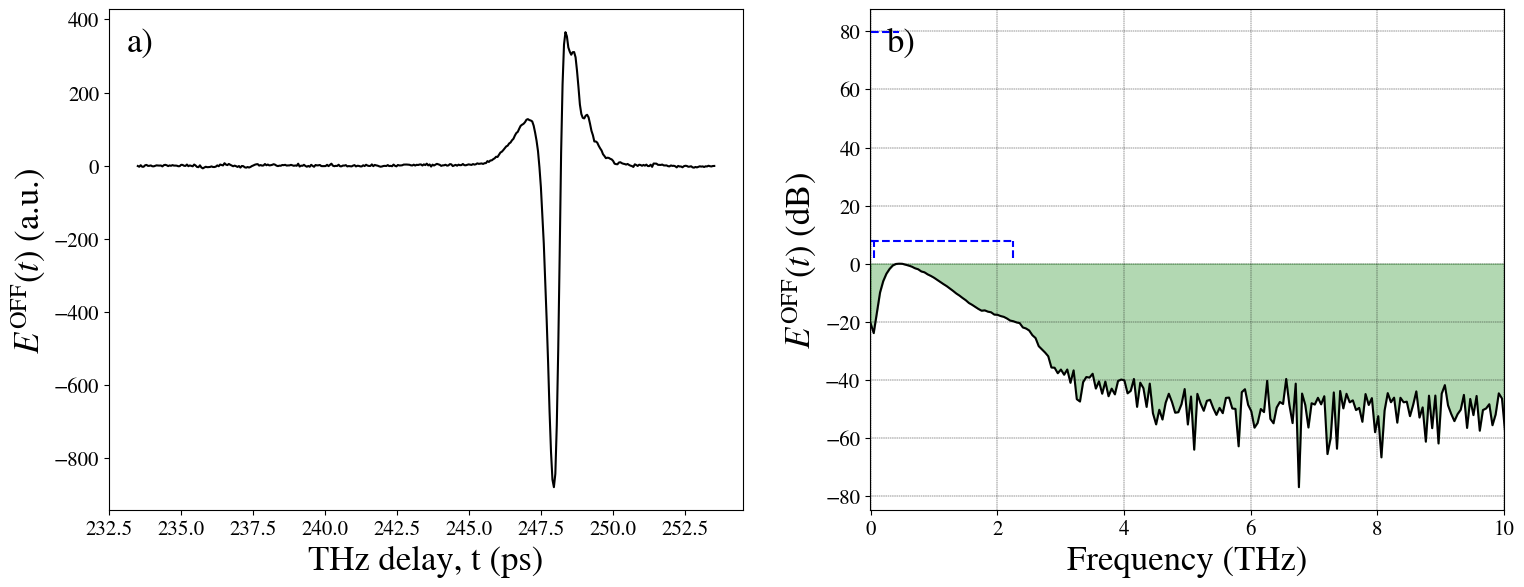

In [169]:
dataframe = generate_cleaned_up_dataframe("D:/Aldric/250822/1_vacuum_pumped_Dark THz.txt")
BW_lower_index, max_fft_E_off_index, BW_upper_index, bandwidth = extract_bandwidth(dataframe)
dark_axs = plot_dark_spectrum(dataframe,
                              in_dB = True,
                              BW_lower_index=BW_lower_index,
                              max_fft_E_off_index=max_fft_E_off_index,
                              BW_upper_index=BW_upper_index)


In [ ]:
labview_data = generate_legacy_dataframe("D:/Aldric/250822/nitrogen_purged labview.txt")
python_data = generate_cleaned_up_dataframe("D:/Aldric/250822/1_nitrogen_purged_Dark THz")


In [108]:
def plot_from_dataframe(x_column,
                        y_column,
                        title="Data Plot",
                        xlabel="X-axis",
                        ylabel="Y-axis"):
    """
    Plots data from a DataFrame.
    
    Parameters:
    - dataframe: pd.DataFrame containing the data to plot
    - x_column: str, name of the column for x-axis
    - y_column: str, name of the column for y-axis
    - title: str, title of the plot
    - xlabel: str, label for x-axis
    - ylabel: str, label for y-axis
    """
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 6))
    plt.plot(x_column, y_column)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.tight_layout
    plt.show()

6356


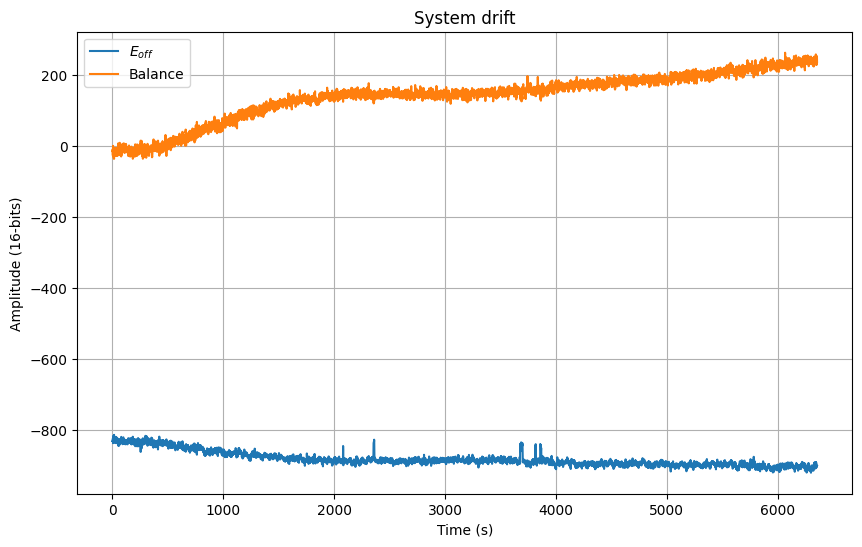

In [57]:
dataframe =  pd.read_csv("D:/Aldric/250822/1_balance drift_Amplitude Tuning.txt",
                        sep="	", header=0)

x_column = (dataframe.index[1:])
y_column = dataframe["D"][1:]-dataframe["A"][1:]

# 7790 seconds
print(len(x_column))

plt.figure(figsize=(10, 6))
plt.plot(x_column, y_column, label=r"$E_{off}$")
plt.plot(x_column, dataframe["A"][1:], label="Balance")
plt.title("System drift")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (16-bits)")
plt.grid()
plt.legend()
plt.tight_layout
plt.show()

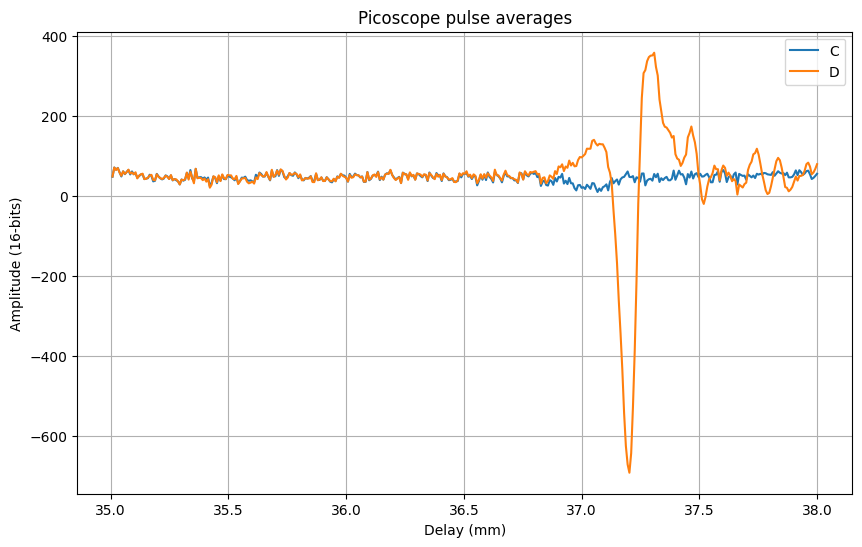

In [42]:
test_pulse = pd.read_csv("D:/Aldric/250822/1_initial_on_on_Dark THz.txt",
                        sep="	", header=0)

# A = On Off
# B = Off Off
# C = On On

x_column = (test_pulse["Delay (mm)"][1:])
A = test_pulse["A"][1:]
B = test_pulse["B"][1:]
C = test_pulse["C"][1:]
D = test_pulse["D"][1:]

plt.figure(figsize=(10, 6))
# plt.plot(x_column, A, label="A")
# plt.plot(x_column, B, label="B")
plt.plot(x_column, C, label="C")
plt.plot(x_column, D, label="D")
plt.title("Picoscope pulse averages")
plt.xlabel("Delay (mm)")
plt.ylabel("Amplitude (16-bits)")
plt.grid()
plt.legend()
plt.tight_layout
plt.show()

37.1578947368421


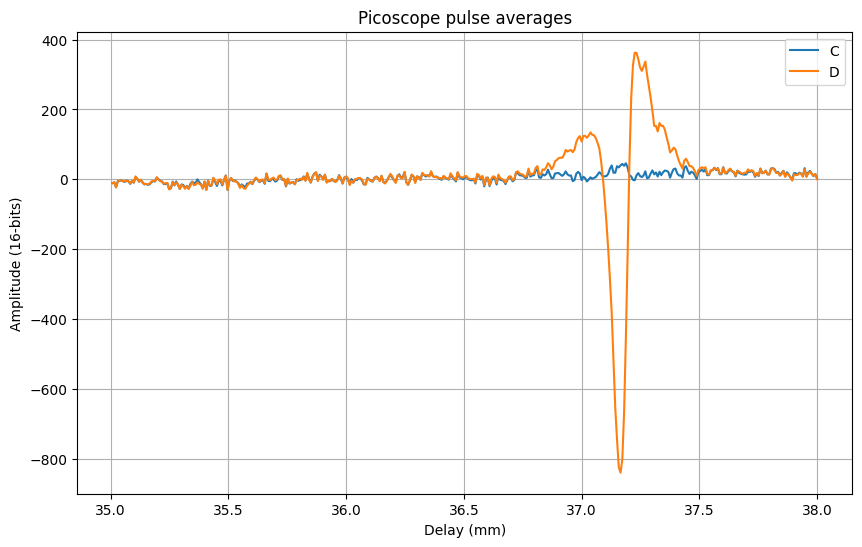

In [53]:
test_pulse = pd.read_csv("D:/Aldric/250822/1_vacuum_pumped_Dark THz.txt",
                        sep="	", header=0)

x_column = (test_pulse["Delay (mm)"][1:])
A = test_pulse["A"][1:]
B = test_pulse["B"][1:]
C = test_pulse["C"][1:]
D = test_pulse["D"][1:]

E_off = D-A
max = E_off.argmin()

print(test_pulse["Delay (mm)"][max])

plt.figure(figsize=(10, 6))
# plt.plot(x_column, A, label="A")
# plt.plot(x_column, B, label="B")
plt.plot(x_column, C, label="C")
plt.plot(x_column, D, label="D")
plt.title("Picoscope pulse averages")
plt.xlabel("Delay (mm)")
plt.ylabel("Amplitude (16-bits)")
plt.grid()
plt.legend()
plt.tight_layout
plt.show()

37.21804511278196


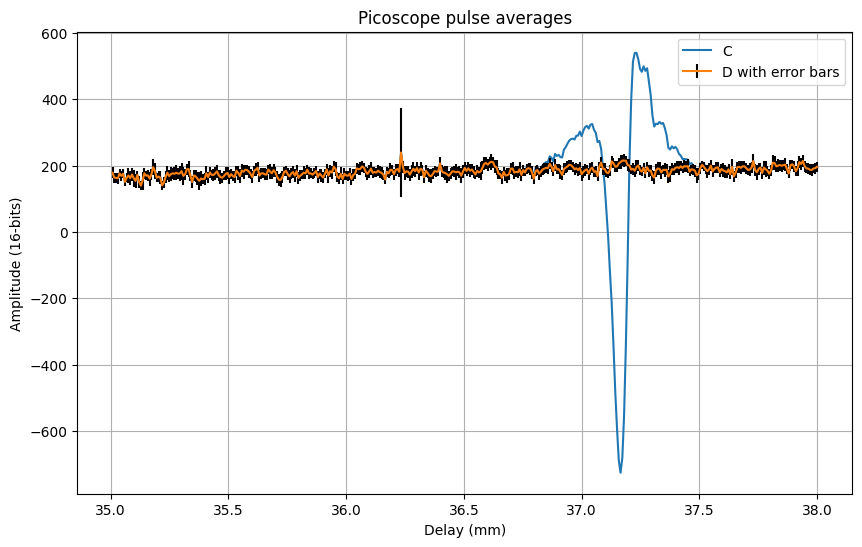

In [62]:
test_pulse = pd.read_csv("D:/Aldric/250823/1_test_2_Dark THz.txt",
                        sep="	", header=0)

x_column = (test_pulse["Delay (mm)"][1:])
A = test_pulse["A"][1:]
B = test_pulse["B"][1:]
C = test_pulse["C"][1:]
D = test_pulse["D"][1:]
D_err = test_pulse["Background noise"][1:]

E_off = D-A
max = E_off.argmin()

print(test_pulse["Delay (mm)"][max])

plt.figure(figsize=(10, 6))
# plt.plot(x_column, A, label="A")
# plt.plot(x_column, B, label="B")
plt.plot(x_column, C, label="C")
# plt.plot(x_column, D, label="D")
plt.errorbar(x_column, D, yerr=D_err, ecolor = "black", label = "D with error bars")
plt.title("Picoscope pulse averages")
plt.xlabel("Delay (mm)")
plt.ylabel("Amplitude (16-bits)")
plt.grid()
plt.legend()
plt.tight_layout
plt.show()

37.21804511278196


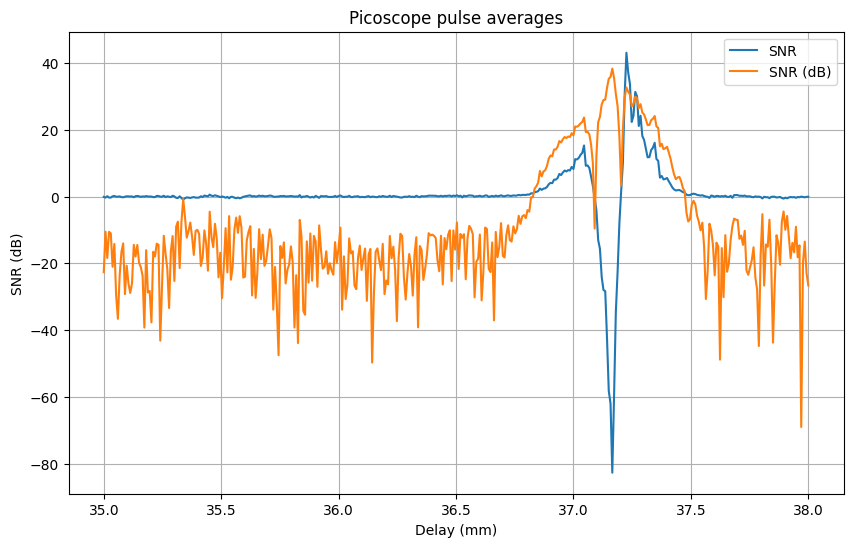

In [78]:
# "D:/Aldric/250823/1_test_2_Dark THz.txt"
# "D:/Aldric/250822/1_vacuum_pumped_Dark THz.txt"
test_pulse = pd.read_csv("D:/Aldric/250822/1_vacuum_pumped_Dark THz.txt",
                        sep="	", header=0)

x_column = (test_pulse["Delay (mm)"])
A = test_pulse["A"]
B = test_pulse["B"]
C = test_pulse["C"]
D = test_pulse["D"]
err = test_pulse["Emitter noise"]

E_off_SNR = (C-D)/err
E_off_SNR_dB = 20*np.log10(abs(E_off_SNR))

E_off_SNR = (D-A)/err
E_off_SNR_dB = 20*np.log10(abs(E_off_SNR))

max = E_off.argmin()

print(test_pulse["Delay (mm)"][max])

plt.figure(figsize=(10, 6))
# plt.plot(x_column, A, label="A")
# plt.plot(x_column, err, label="noise")
plt.plot(x_column, E_off_SNR, label="SNR")
plt.plot(x_column, E_off_SNR_dB, label="SNR (dB)")
plt.title("Picoscope pulse averages")
plt.xlabel("Delay (mm)")
plt.ylabel("SNR (dB)")
plt.grid()
plt.legend()
plt.tight_layout
plt.show()

37.21804511278196


C:\Users\sk2010\AppData\Local\Temp\ipykernel_19628\2286628985.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


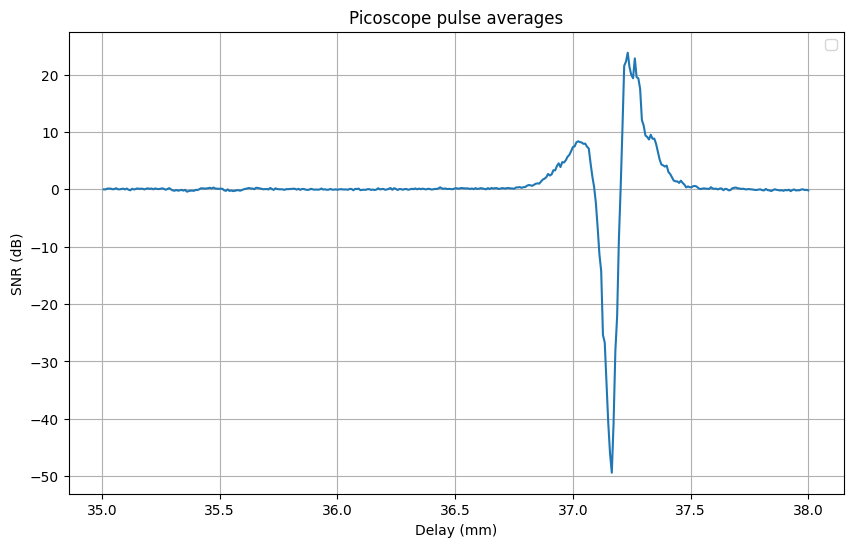

In [70]:
test_pulse = pd.read_csv("D:/Aldric/250823/1_test_2_Dark THz.txt",
                        sep="	", header=0)

x_column = (test_pulse["Delay (mm)"][1:])
A = test_pulse["A"][1:]
B = test_pulse["B"][1:]
C = test_pulse["C"][1:]
D = test_pulse["D"][1:]
err = test_pulse["Emitter noise"][1:]

E_off_SNR = (C-D)/err
max = E_off.argmin()

print(test_pulse["Delay (mm)"][max])

plt.figure(figsize=(10, 6))
# plt.plot(x_column, A, label="A")
# plt.plot(x_column, err, label="noise")
plt.plot(x_column, E_off_SNR)
plt.title("Picoscope pulse averages")
plt.xlabel("Delay (mm)")
plt.ylabel("SNR (dB)")
plt.grid()
plt.legend()
plt.tight_layout
plt.show()

# Useful functions
Here are some useful functions to help with understanding the data acquisition code, data, or just some THz stuff.

### Converting N-bit data to the voltage in decimal place


In [ ]:
N = 16
def bits_to_voltage(data, n=N, v_ref=10.0):
    """
    Convert N-bit data to voltage in decimal place.
    
    Parameters:
    - data: The raw data to convert.
    - n: Number of bits (default is 16).
    - v_ref: Amplitude of reference voltage (default is 10.0).
    
    Returns:
    - Converted voltage values.
    """
    return (data / (2**n - 1)) * v_ref

In [4]:
print(bits_to_voltage(2000))

0.3051804379339284
